# Decision Tree

## Imports
In this section we import the libraries necessary to analyse and process our data.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

## Import & Pre-process Data
The first thing we do is read in our data. This data can be found at https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset/data. Once we've done this we drop all rows with empty values and the `id` column as it is not necessary for our pre-processing. After dropping, we take the `weight`, `height`, `ap_hi`, `ap_low` and `age` columns and convert them to be categorical.

For the `weight` and `height` columns, we categorize them by using the values to calculate and create the `BMI` column and then categorizing those values. To do this we first divide the values in the `height` column by 100 to get the values in meters, putting them into the new `heights_m` column. Once this is done we get our `BMI` values using the sum `df['weight'] / (df['height_m'] ** 2)`. After this we drop the `heights_m` column as it is no longer needed.

With the `ap_hi` and `ap_low` columns we first get the average blood pressure by getting the mean value of the two columns combined. After this we categorize the data with a "High" blood pressure being above 120, "Medium" being between 80 and 120 and 'Low' being under 80.

For the `ages` column we first divide the column by 365 to convert the data from days into years. After this we once again split the data into the categories "Under 18", "18 - 21", "21 - 40", "41 - 60", "61 - 80" and "80+".

Finally, we use a LabelEncoder to convert our categorical labels into numerical labels. This is important as some of our data is ordinal (has an inherent order, for example `bp_category` has "Low", "Normal" and "High" categories which could be placed in a specific order). Once our ordinal categories have been encoded we drop any data that will not be used from this point (`age`, `gender`, `height`, `weight`, `ap_hi` and `ap_lo`).



In [2]:
df=pd.read_csv("cardio_train.csv", sep=";")

df = df.dropna(axis=0)
df = df.drop('id', axis=1)

df['height_m'] = df['height'] / 100

df['BMI'] = df['weight'] / (df['height_m'] ** 2)

df = df.drop(columns=['height_m'])

def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df['BMI_category'] = df['BMI'].apply(categorize_bmi)

df['bp_mean'] = df[['ap_hi', 'ap_lo']].mean(axis=1)

def categorize_bp(mean_bp):
    if mean_bp > 120:
        return 'High'
    elif mean_bp >= 80:
        return 'Normal'
    else:
        return 'Low'

df['bp_category'] = df['bp_mean'].apply(categorize_bp)

df['ages_year'] = df['age'] // 365

def categorize_age(ages_year):
    if ages_year < 18:
        return 'Under 18'
    elif 18 <= ages_year <= 21:
        return '18 - 21'
    elif 21 < ages_year <= 40:
        return '21 - 40'
    elif 40 < ages_year <= 60:
        return '41 - 60'
    elif 60 < ages_year <= 80:
        return '61 - 80'
    else:
        return '80+'

df['age_category'] = df['ages_year'].apply(categorize_age)

encoder = LabelEncoder()
df['BMI_category_encoded'] = encoder.fit_transform(df['BMI_category'])
df['bp_category_encoded'] = encoder.fit_transform(df['bp_category'])
df['age_category_encoded'] = encoder.fit_transform(df['age_category'])

df = df.drop(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo'], axis=1)

df.head()

,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI_category,bp_mean,bp_category,ages_year,age_category,BMI_category_encoded,bp_category_encoded,age_category_encoded
0,1,1,0,0,1,0,21.967120,Normal,95.0,Normal,50,41 - 60,0,2,1
1,3,1,0,0,1,1,34.927679,Obese,115.0,Normal,55,41 - 60,1,2,1
2,3,1,0,0,0,1,23.507805,Normal,100.0,Normal,51,41 - 60,0,2,1
3,1,1,0,0,1,1,28.710479,Overweight,125.0,High,48,41 - 60,2,0,1
4,1,1,0,0,0,0,23.011177,Normal,80.0,Normal,47,41 - 60,0,2,1


## Fit Data
Once we have processed the data we define independent (what we're using to predict) and dependant variables (what we want to predict). Once this is done we split the data into training and testing sets. We pass in the parameter `train_size` which splits our data so that 40% of the provided data for training the model, with the remaining 60% being used for testing.

After this we create our Random Forest model and fit our training data to it. We then use our model to make predictions based on the provided data.

In [3]:
X = df[['BMI_category_encoded', 'age_category_encoded',  'bp_category_encoded', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']]
Y = df['cardio']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.4)

tree = RandomForestClassifier()
tree.fit(X_train, Y_train)

Y_pred = tree.predict(X_test)

## Display Data
Once our model has been fitted with data and is making predictions, we display the data using a confusion matrix to show the amount of True Positives, False Positives, True Negatives and False Negatives that our model has predicted. We also display some metrics about the model, which are as follows:
- Accuracy: The percentage of all predictions (both "yes" and "no") that the model got correct.
- Precision: Of all the cases where the model predicted "yes," the percentage that were actually true positives.
- Recall: Of all the actual "yes" cases in the data, the percentage that the model successfully identified.
- F1-Score: A balanced percentile measure of the model's precision and recall.



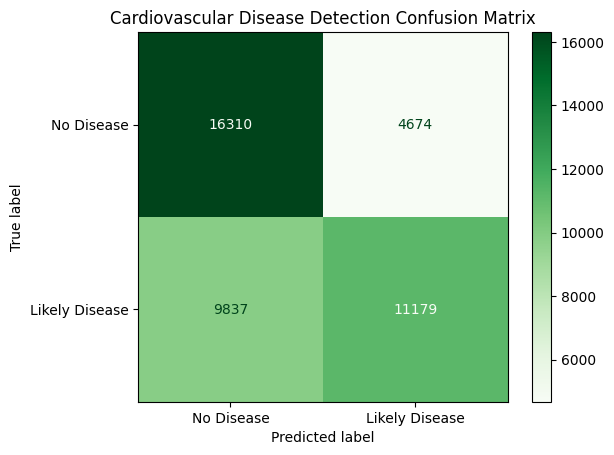

Accuracy: 0.65
Precision: 0.71
Recall: 0.53
F1-Score: 0.61


In [4]:
cm = confusion_matrix(Y_test, Y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Disease", "Likely Disease"])

cm_display.plot(cmap="Greens")  # Optional: specify color map
plt.title("Cardiovascular Disease Detection Confusion Matrix")  # Add title
plt.show()

print(f"Accuracy: {accuracy_score(Y_test, Y_pred):.2f}")
print(f"Precision: {precision_score(Y_test, Y_pred):.2f}")
print(f"Recall: {recall_score(Y_test, Y_pred):.2f}")
print(f"F1-Score: {f1_score(Y_test, Y_pred):.2f}")